## Cats vs Dogs partial - CNN
- 부분 데이터 (train + test):
  -고양이: 1000 + 500, 개: 1000+ 500

In [63]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-11-08 06:42:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.207, 108.177.125.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  21.9MB/s    in 3.0s    

2023-11-08 06:43:02 (21.9 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [64]:
!unzip cats_and_dogs_filtered.zip > /dev/null   #아웃풋 출력을 버리겠다

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [65]:
!rm -rf cats_and_dogs_filtered  # 해당 파일 지우는 명령어

In [66]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

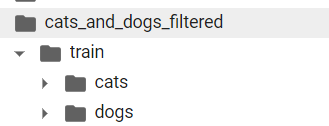

In [68]:
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [69]:
# 파일의 갯수
import os

for dir in [train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
  fnames = os.listdir(dir)
  print(f'{dir}: {len(fnames):,d}')

cats_and_dogs_filtered/train/cats: 1,000
cats_and_dogs_filtered/train/dogs: 1,000
cats_and_dogs_filtered/validation/cats: 500
cats_and_dogs_filtered/validation/dogs: 500


- 이미지 확인

In [70]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

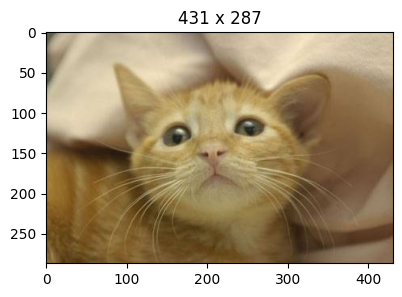

In [71]:
# 1) Pillow Image
from PIL import Image
img = Image.open(fname)
plt.figure(figsize=(5,3))
plt.title(f'{img.width} x {img.height}')
plt.imshow(img);

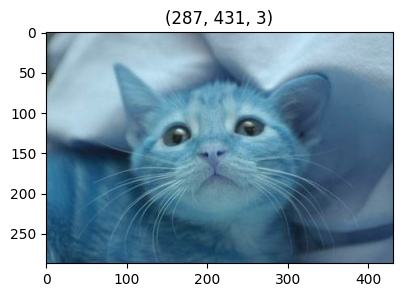

In [72]:
# 2) OpenCV image: 순서가 RGB가 아니고 BGR (블루계열..)
import cv2
img2 = cv2.imread(fname)
plt.figure(figsize=(5,3))
plt.title(img2.shape)         # OpenCV로 읽으면 numpy ndarray로 읽힘
plt.imshow(img2);

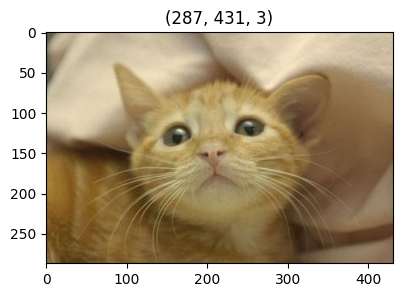

In [73]:
img2 = cv2.imread(fname)
plt.figure(figsize=(5,3))
plt.title(img2.shape)         # OpenCV로 읽으면 numpy ndarray로 읽힘
plt.imshow(img2[:,:,::-1]);   # 3번째 칼라만 거꾸로 바꿔주면 원래 색으로 돌아옴

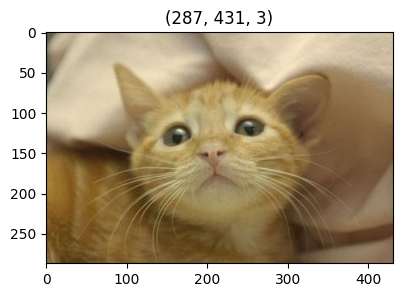

In [74]:
plt.figure(figsize=(5,3))
plt.title(img2.shape)
img3 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img3);

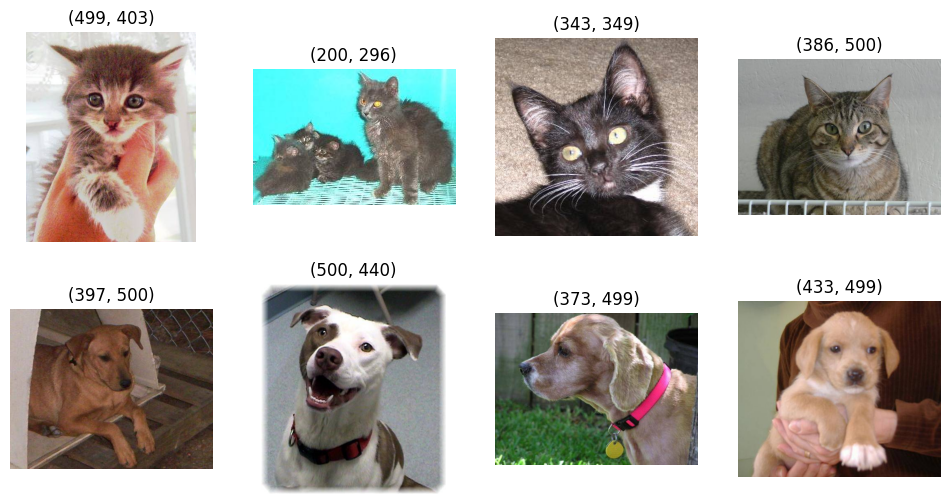

In [75]:
plt.figure(figsize=(12,6))
for i in range(4):
  plt.subplot(2, 4, i+1)
  cat = cv2.imread(f'{train_cats_dir}/cat.10{i}.jpg')[:,:,::-1]
  plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])

  plt.subplot(2, 4, i+5)
  dog = cv2.imread(f'{train_dogs_dir}/dog.10{i}.jpg')[:,:,::-1]
  plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])

- 모델 구성

In [76]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [77]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),   # 이미지를 150x150의 크기로 변환해주는 무언가가 필요함
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [78]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.path = 'best-cats-and-dogs.h5'
mc = ModelCheckpoint(model.path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

- 파일에서 이미지 데이터를 읽어서 학습시키는 방법

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [80]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
#class_mode='binarry' 하는 이유는 Cats, Dogs가 두개가 있어서
#target_size=(150,150) 해당 사이즈로 이미지 사이즈 변형

test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 학습

In [81]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100, steps_per_epoch=100,    # batch_size(20) x step_per_epoch(100) = 2000, 트레인 데이터가 2,000개
    validation_steps=50,          # batch_size(20) x step_per_epoch(50) = 1000, 검증 데이터가 1,000개
    callbacks=[mc, es]
    )

# 런타임 실행전 GPU로 유형 변경 후 런타임 모두실행

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.7126 - accuracy: 0.5520
Epoch 1: val_loss improved from inf to 0.63976, saving model to best-cats-and-dogs.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 8s 68ms/step - loss: 0.7115 - accuracy: 0.5540 - val_loss: 0.6398 - val_accuracy: 0.6420
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.6338
Epoch 2: val_loss improved from 0.63976 to 0.61316, saving model to best-cats-and-dogs.h5
100/100 [==============================] - 7s 66ms/step - loss: 0.6431 - accuracy: 0.6340 - val_loss: 0.6132 - val_accuracy: 0.6520
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5858 - accuracy: 0.6859
Epoch 3: val_loss did not improve from 0.61316
100/100 [==============================] - 5s 51ms/step - loss: 0.5862 - accuracy: 0.6850 - val_loss: 0.6234 - val_accuracy: 0.6410
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7195
Epoch 4: val_loss did not improve from 0.61316
100/100 [==============================] - 6s 62ms/step - loss: 0.5521 - accuracy: 0.7195 - val_loss: 0.6265 - val_accuracy: 0.63

In [82]:
best_model = load_model(model.path)
best_model.evaluate(test_generator)


50/50 [==============================] - 2s 34ms/step - loss: 0.6132 - accuracy: 0.6520


[0.6131553053855896, 0.6520000100135803]

- 테스트 이미지 분류

In [83]:
from google.colab import files
up = files.upload()

KeyboardInterrupt: ignored

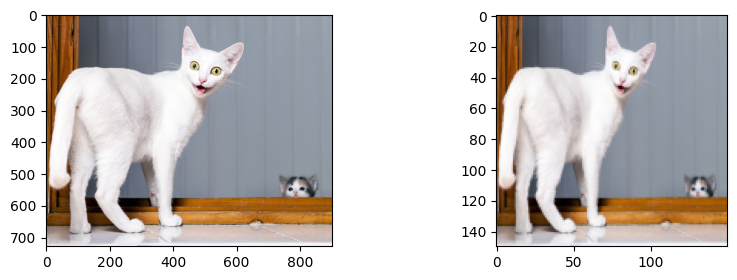

In [84]:
img = cv2.imread('cat2.jpg')[:,:,::-1]
img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [85]:
best_model.predict(img2.reshape(-1, 150, 150, 3))  # -1 은 앞의 차원을 늘려서

1/1 [==============================] - 0s 74ms/step


array([[4.4558514e-35]], dtype=float32)

In [86]:
for fname in up.keys():
  img = cv2.imread(fname)[:,:,::-1]
  img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
  classes = best_model.predict(img2.reshape(-1,150,150,3), verbose=0)
  print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

1.0000 cat1.jpg is a dog
0.0000 cat2.jpg is a cat
1.0000 cat3.jpg is a dog
1.0000 dog1.jpg is a dog
1.0000 dog2.jpg is a dog
1.0000 dog3.jpg is a dog


In [ ]:
#업로드한 개,고양이 사진 지우는 리눅스 코드
!rm cat?*
!rm dog?*